<a href="https://colab.research.google.com/github/rsuwa/self-driving-mini-car/blob/main/learn_steer_throttle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/content


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/train_data_C | wc -l

11329


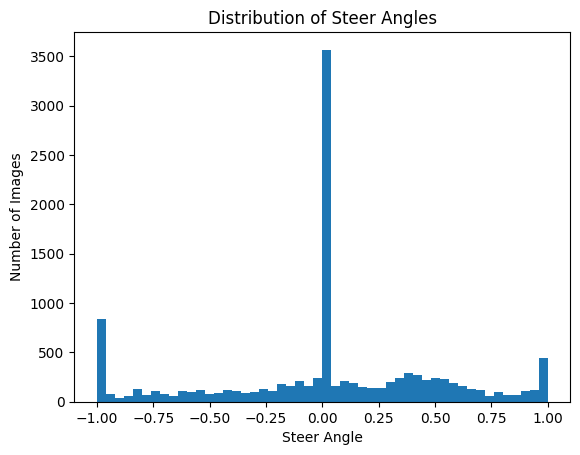

In [4]:
import os
import matplotlib.pyplot as plt

# フォルダのパスを設定
folder_path = "/content/drive/MyDrive/train_data_C"  # 例: "/path/to/your/folder"

# ステア角のリストを作成
steer_angles = []

# フォルダ内のすべてのファイルをループ
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):  # .jpgファイルのみを対象
        # ステア角を取得
        angle = filename.split("_")[0]
        try:
            steer_angles.append(float(angle))
        except ValueError:
            print(f"Could not convert {angle} to float from filename {filename}")
            continue

# ステア角の分布をヒストグラムとしてプロット
plt.hist(steer_angles, bins=50)
plt.title("Distribution of Steer Angles")
plt.xlabel("Steer Angle")
plt.ylabel("Number of Images")
plt.show()


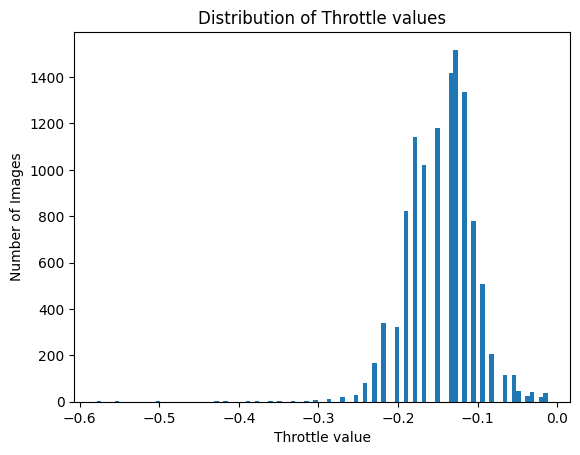

In [5]:
import os
import matplotlib.pyplot as plt

# フォルダのパスを設定
folder_path = "/content/drive/MyDrive/train_data_C"  # 例: "/path/to/your/folder"

# ステア角のリストを作成
throttles = []

# フォルダ内のすべてのファイルをループ
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):  # .jpgファイルのみを対象
        # throttle値を取得
        throttle = filename.split("_")[1]
        try:
            throttles.append(float(throttle))
        except ValueError:
            print(f"Could not convert {throttle} to float from filename {filename}")
            continue

# ステア角の分布をヒストグラムとしてプロット
plt.hist(throttles, bins=100)
plt.title("Distribution of Throttle values")
plt.xlabel("Throttle value")
plt.ylabel("Number of Images")
plt.show()


In [6]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import glob
import PIL.Image
import os
import numpy as np

## スロットル値が0に近い画像を削除

In [7]:
import os

# フォルダのパスを設定
folder_path = "/content/drive/MyDrive/train_data_C"  # 例: "/path/to/your/folder"
throttle_threshold = 0.0005 # スロットル値がこの値未満のファイルを削除
steer_angle_threshold = 0.05
cnt = 0
# フォルダ内のすべてのファイルをループ
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):  # .jpgファイルのみを対象
        # スロットル値を取得
        throttle_str = filename.split("_")[1]
        # ステア値を取得
        steer_angle_str = filename.split("_")[0]
        try:
            throttle = float(throttle_str)
            steer_angle = float(steer_angle_str)

            # スロットル値が指定された閾値未満かをチェック
            if abs(throttle) < throttle_threshold:
                # and abs(steer_angle) < steer_angle_threshold:
                file_path = os.path.join(folder_path, filename)
                os.remove(file_path)
                print(f"Removed {filename}, steer={steer_angle}, throttle={throttle}")
                cnt += 1
        except ValueError:
            print(f"Could not convert {throttle_str} to float from filename {filename}")
            continue
print(cnt)


0


In [8]:
def get_steering(path):
    """Gets the steering value from the image filename"""
    gets = path.split('_')
    return float(gets[0])

def get_speed(path):
    """Gets the speed value from the image filename"""
    gets = path.split('_')
    return float(gets[1])

class SSDataset(torch.utils.data.Dataset):

    def __init__(self, directory, random_hflips=False):
        self.directory = directory
        self.random_hflips = random_hflips
        self.image_paths = glob.glob(os.path.join(self.directory, '*.jpg'))
        self.color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.3)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        image = PIL.Image.open(image_path)
        x = float(get_steering(os.path.basename(image_path)))
        y = float(get_speed(os.path.basename(image_path)))

        image = self.color_jitter(image)
        image = transforms.functional.resize(image, (224, 224))
        image = transforms.functional.to_tensor(image)
        image = image.numpy()[::-1].copy()
        image = torch.from_numpy(image)
        image = transforms.functional.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        return image, torch.tensor([x, y]).float()

dataset = SSDataset('/content/drive/MyDrive/train_data_C', random_hflips=False)

In [9]:
test_percent = 0.1
num_test = int(test_percent * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - num_test, num_test])


In [10]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 64.8MB/s]


In [12]:
model.fc = torch.nn.Linear(512, 2)
device = torch.device('cuda')
model = model.to(device)

# Frozen for modle layer1 to layer3
for l in model.layer1.parameters():
    l.requires_grad=False
for l in model.layer2.parameters():
    l.requires_grad=False
for l in model.layer3.parameters():
    l.requires_grad=False

In [13]:
EARLY_STOP = True


NUM_EPOCHS = 100
BEST_MODEL_PATH = 'best_steering_model_ResNet.pth'
best_loss = 1e9
optimizer = optim.Adam(model.parameters())

es_counter = 0
for epoch in range(NUM_EPOCHS):

    model.train()
    train_loss = 0.0
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        loss.backward()
        train_loss += float(loss)
        optimizer.step()
    train_loss /= len(train_loader)

    model.eval()
    test_loss = 0.0
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        test_loss += float(loss)
    test_loss /= len(test_loader)
    print('%d, %f, %f' % (epoch, train_loss, test_loss))
    if test_loss < best_loss:
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        best_loss = test_loss
        es_counter=0
    else:
        if es_counter == 7 and EARLY_STOP:
            print("Early Stopping EPOCH[{}], val_loss {:4f}".format(epoch, best_loss))
            break
        else:
            es_counter += 1


0, 0.053774, 0.023254
1, 0.024639, 0.023941
2, 0.019197, 0.017443
3, 0.018068, 0.018411
4, 0.017379, 0.016326
5, 0.015373, 0.017795
6, 0.015330, 0.021351
7, 0.014435, 0.016987
8, 0.014970, 0.013548
9, 0.014793, 0.015292
10, 0.013133, 0.017880
11, 0.012625, 0.022435
12, 0.012007, 0.014224
13, 0.011388, 0.013904
14, 0.010602, 0.015475
15, 0.010167, 0.016328
16, 0.009322, 0.014057
Early Stopping EPOCH[16], val_loss 0.013548


In [38]:
TEST_DATA_IMAGE = '/content/drive/MyDrive/train_data_C/0.937970_-0.135995_39040dae-5a99-11ee-ae33-0242e6b385a8.jpg'

model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(512, 2)
model.load_state_dict(torch.load('best_steering_model_ResNet.pth'))
model = model.to(device)
model = model.eval()
image_path = TEST_DATA_IMAGE
image = PIL.Image.open(image_path)
image = transforms.functional.resize(image, (224, 224))
image = transforms.functional.to_tensor(image)
image = image.numpy()[::-1].copy()
image = torch.from_numpy(image)
image = transforms.functional.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)
outputs = model(image[None, ...])
print(outputs)

tensor([[ 0.9941, -0.1543]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [39]:
image = PIL.Image.open(image_path)
image_orig_size = image.size

sample_image = transforms.functional.resize(image, (224, 224))


sample_image = transforms.functional.to_tensor(sample_image)
sample_image = sample_image.numpy()[::-1].copy()
sample_image = torch.from_numpy(sample_image)
sample_image = transforms.functional.normalize(sample_image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)

In [40]:
# https://tech.jxpress.net/entry/2018/12/12/130057
# https://jacobgil.github.io/deeplearning/vehicle-steering-angle-visualizations
class GradCAM:
    def __init__(self, model, feature_layer):
        self.model = model
        self.feature_layer = feature_layer
        self.model.eval()
        self.feature_grad = None
        self.feature_map = None
        self.hooks = []

        # 最終層逆伝播時の勾配を記録する
        def save_feature_grad(module, in_grad, out_grad):
            self.feature_grad = out_grad[0]
        self.hooks.append(self.feature_layer.register_backward_hook(save_feature_grad))

        # 最終層の出力 Feature Map を記録する
        def save_feature_map(module, inp, outp):
            self.feature_map = outp[0]
        self.hooks.append(self.feature_layer.register_forward_hook(save_feature_map))

    def forward(self, x):
        return self.model(x)

    def backward_on_target(self,output):
        self.model.zero_grad()
        output.backward()

    def clear_hook(self):
        for hook in self.hooks:
            hook.remove()


In [41]:
model.eval()
grad_cam = GradCAM(model=model, feature_layer=list(model.layer4.modules())[-1])

In [42]:
model_output = grad_cam.forward(sample_image[None, ...])
print(model_output)
#model_output.backward()
grad_cam.backward_on_target(model_output[0][0])

tensor([[ 0.9941, -0.1543]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [43]:
import numpy as np
# Get feature gradient
feature_grad = grad_cam.feature_grad.data.cpu().numpy()[0]
# Get weights from gradient
weights = np.mean(feature_grad, axis=(1, 2))  # Take averages for each gradient
# Get features outputs
feature_map = grad_cam.feature_map.data.cpu().numpy()
grad_cam.clear_hook()

In [44]:
# Get cam
cam = np.sum((weights * feature_map.T), axis=2).T
cam = np.maximum(cam, 0)  # apply ReLU to cam

In [45]:
print(cam)

[[0.00676942 0.00568169 0.00753299 0.00693932 0.00548564 0.00267306
  0.0007839 ]
 [0.01131999 0.01336562 0.02203597 0.02069377 0.01747516 0.01729367
  0.00748387]
 [0.01591337 0.02160628 0.02195418 0.02479064 0.02722544 0.03079736
  0.01522081]
 [0.02143985 0.02474972 0.0196396  0.02508132 0.02942497 0.03438896
  0.01675905]
 [0.01845087 0.015064   0.01050056 0.01264868 0.01755879 0.02082975
  0.00843379]
 [0.00943202 0.00808686 0.01183158 0.01505878 0.01942895 0.02393871
  0.01071573]
 [0.00671737 0.01033783 0.01330873 0.01442466 0.01520124 0.01475586
  0.00755012]]


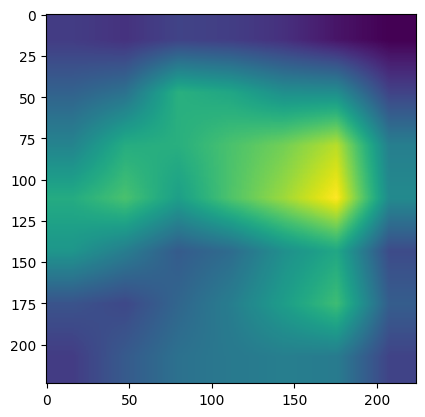

In [46]:
#(cam*10000).astype(np.uint8)
import cv2
import matplotlib.pyplot as plt
cam = cv2.resize(cam, (224,224))
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
plt.imshow(cam)
plt.show()

In [47]:
activation_heatmap = np.expand_dims(cam, axis=0).transpose(1,2,0)
org_img = np.asarray(image.resize((224,224)))
img_with_heatmap = np.multiply(np.float32(activation_heatmap), np.float32(org_img))
img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)
org_img = cv2.resize(org_img, image_orig_size)

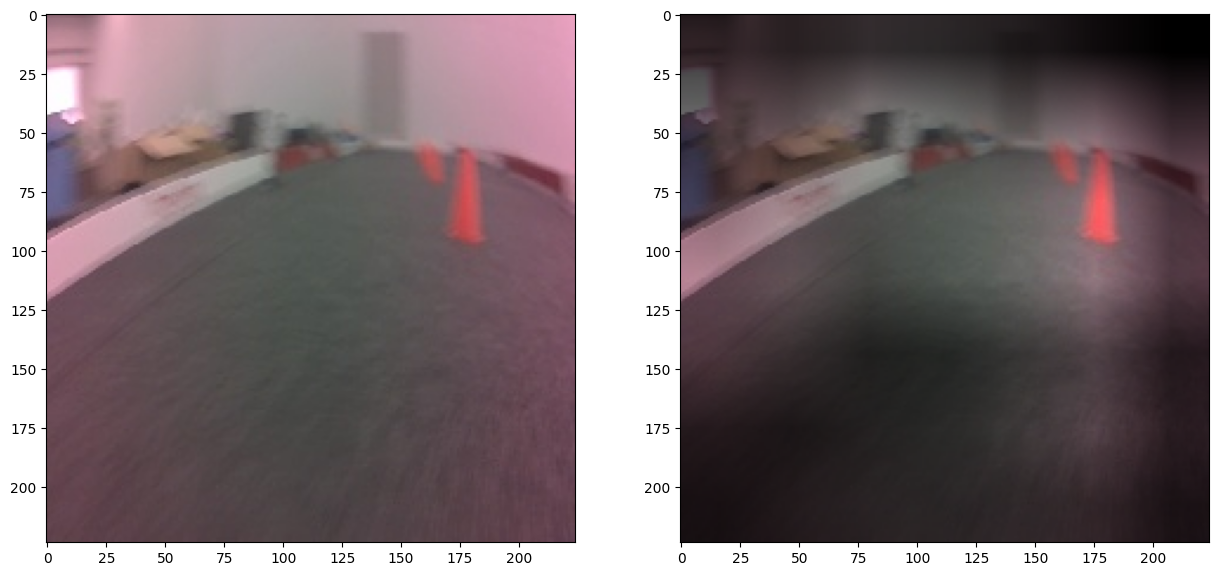

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(org_img)
plt.subplot(1,2,2)
plt.imshow(cv2.resize(np.uint8(255 * img_with_heatmap), image_orig_size))
plt.show()